# Analysing Question 1.2 results

The following notebook analyses the results using helper code. First, let's define methods that will asist us further.

In [92]:
# Load the predicted and gold results

def load(predicted, gold):
    out = []
    for file_name in [predicted, gold]:
        with open(file_name, 'r') as f:
            out.append(f.read().splitlines())
    return out
    
predicted, gold = load('./output/predicted12j.txt', './data/heb-ctrees.joint')
assert len(predicted) <= len(gold)

In [263]:
# Load evalb output file to a dataframe
from collections import defaultdict
import pandas as pd

def load_eval(file_name):
    out = defaultdict(dict)
    t_tags = ['index', '_', '_', '_', 'parent', 'tag']
    nt_tags = ['index', '_', '_', '_', 'start', 'end', 'tag']
    int_tags = ['index', 'start', 'end']
    meta_tags = ['ID', 'Len.', 'Stat.', 'Recal', 'Prec.', 'Matched Bracket', 'Bracket gold', 'Bracket test', 'Cross Bracket', 'Words', 'Correct Tags', 'Tag Accracy']
    with open(file_name, 'r') as f:
        started = False

        for line in f:
            split = [word for word in line.strip().split(' ') if word]
            if len(split) == 12:
                try:
                    _ = float(split[-2])  # Only meta lines have floats at [-2]
                    line_num = int(split[0])
                    out[line_num]['line'] = gold[line_num - 1]
                    out[line_num]['meta'] = dict(zip(meta_tags, map(float, split)))
                    continue
                except ValueError:
                    pass

            if line == '============================================================================\n':
                if not started:
                    started = True
                else:
                    return out  # ended
            elif not started:
                continue
            else:
                if len(split) == 12 or len(split) == 14:
                    parsing_terminals = len(split) == 12
                    keys = ['t-predicted', 't-gold'] if parsing_terminals else ['nt-predicted', 'nt-gold']
                    tags = t_tags if parsing_terminals else nt_tags

                    half = int(len(split) / 2)
                    for i, place in enumerate(keys):
                        out[line_num][place] = out[line_num].get(place, [])
                        place_tags = dict(zip(tags, split[i * half:(i + 1) * half]))
                        for t in int_tags:
                            if t in place_tags:
                                place_tags[t] = int(place_tags[t])
                        out[line_num][place].append(place_tags)
    return out

evalb = load_eval('output/evalb-result12j.txt')

data = [r['meta'] for r in evalb.values()]
evalb_df = pd.DataFrame(data)

In [264]:
evalb[1]

{'line': '(TOP (S (VP (VB KTWB)) (SBAR (yyCLN yyCLN) (S (yyQUOT yyQUOT) (S (PP (IN B) (NP (NN XWKMH))) (VP (VB EFH)) (PP (IN L) (NP (PRP ATH))) (NP (NN MLXMH))) (yyQUOT yyQUOT))) (yyDOT yyDOT)))',
 'meta': {'ID': 1.0,
  'Len.': 11.0,
  'Stat.': 0.0,
  'Recal': 100.0,
  'Prec.': 100.0,
  'Matched Bracket': 12.0,
  'Bracket gold': 12.0,
  'Bracket test': 12.0,
  'Cross Bracket': 0.0,
  'Words': 11.0,
  'Correct Tags': 11.0,
  'Tag Accracy': 100.0},
 't-predicted': [{'index': 0, '_': ':', 'parent': 'VB', 'tag': 'KTWB'},
  {'index': 1, '_': ':', 'parent': 'yyCLN', 'tag': 'yyCLN'},
  {'index': 2, '_': ':', 'parent': 'yyQUOT', 'tag': 'yyQUOT'},
  {'index': 3, '_': ':', 'parent': 'IN', 'tag': 'B'},
  {'index': 4, '_': ':', 'parent': 'NN', 'tag': 'XWKMH'},
  {'index': 5, '_': ':', 'parent': 'VB', 'tag': 'EFH'},
  {'index': 6, '_': ':', 'parent': 'IN', 'tag': 'L'},
  {'index': 7, '_': ':', 'parent': 'PRP', 'tag': 'ATH'},
  {'index': 8, '_': ':', 'parent': 'NN', 'tag': 'MLXMH'},
  {'index': 9, '

For starters, we notice the obvious. There's a negative correlation between the __length__ of the sentence and the Precision/Recall metrics.

In [94]:
evalb_df.corr()['Len.'].loc[['Prec.', 'Recal']]

Prec.   -0.101653
Recal   -0.107417
Name: Len., dtype: float64

But, suprsingly, the correlation isn't that low, and there's no negative correlation between the __length__ of the sentence and the tag accuracy.

In [95]:
evalb_df.corr()['Len.'].loc[['Tag Accracy']]

Tag Accracy    0.186249
Name: Len., dtype: float64

Now, we move deeper to analyze our __PCFG__ model internals.

Some helper method below:

In [96]:
# Load the trained model
import dill
pickle_file = "./pcfg.p"
with open(pickle_file, "rb") as f:
    pcfg = dill.load(f)

In [218]:
# Display helper methods
import svgling, svgling.html, svgling.figure
from svgling.figure import SideBySide, RowByRow, Caption
from svgling.core import VertAlign
import json
import re
from util.transliteration import to_heb, _trans_symbols
from IPython.core.display import display, HTML

def translate(word):
    if word in _trans_symbols:
        ret = to_heb(word)
        if ret=='"':
            return "\\\""
        return ret
    else:
        return word.lower()+"\\n"+"".join(map(to_heb, word)).replace('"', "\\\"")

def translate_replace(word):
    return word.group(1) + translate(word.group(2)) +  word.group(3)

def to_graph(line):
    formatted = line.replace("(","[").replace(")","]")
    formatted = re.sub(r'([a-zA-Z]+)', r'"\1"',formatted)
    formatted = re.sub(r'(\s\")([a-zA-Z]+)(\"\])', translate_replace, formatted)
    formatted = re.sub(r'\s', r',',formatted)
    graph = json.loads(formatted)
    return graph

def html(text, tag):
    display(HTML(f'<{tag}>{text}</{tag}>'))

def h1(text):
    html(text, 'h1')

def h2(text):
    html(text, 'h2')
    
def h3(text):
    html(text, 'h3')
    
def describe(line_num, p_boxes=None, g_boxes=None):
    meta = evalb[line_num]['meta']
    h2(f'Line {line_num}')
    
    pred_graph = svgling.draw_tree(to_graph(predicted[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    gold_graph = svgling.draw_tree(to_graph(gold[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    
    for b in p_boxes or []:
        pred_graph.box_constituent(b)
    for b in g_boxes or []:
        gold_graph.box_constituent(b)
    
    printer = SideBySide if meta['Len.']<9 else RowByRow
    display(printer(pred_graph,gold_graph))

In [219]:
# PCFG model inspection method

known_words = set(pcfg.reverse_rules['T'].keys())

def to_leafs(line): # return the leafs of a bracket notated line
    return re.findall(r'([\w]+)\)', line)
        
def get_parent_to_child(parent, child, child_side):
    index = 0 if child_side=='left' else 1
    parent_to_child = dict((t,prob) for t, prob in pcfg.rules[parent][pcfg.NON_TERMINAL_RULES].items() 
                           if (len(t)==2 and t[index]==child) or (len(t)==1 and t[0]==child))
    return sorted(parent_to_child.items(), key=lambda t:-t[1])

def get_possible_terminal_tags(terminal):
    return pcfg.reverse_rules['T'].get(terminal.upper(), [])

def get_unknown_score(terminal):
    unknowns = sorted(pcfg.unknown_rules, key=lambda k: -pcfg.unknown_rules[k]) 
    return unknowns.index(terminal)

## Now, let's examin some mistakes:

As we can see in the example below, the marked tokens got the wrong tag, and consequently changed the sentence tree.

This happened as __שיחי__ appeared in the train set only as MNT, which meant __the bushes of__, in a totally different meanining than in the parsed sentence.

This use case shows the CKY may fail to parse sentence with __tokens that have several meanings__, but only appeared with one in the traning.

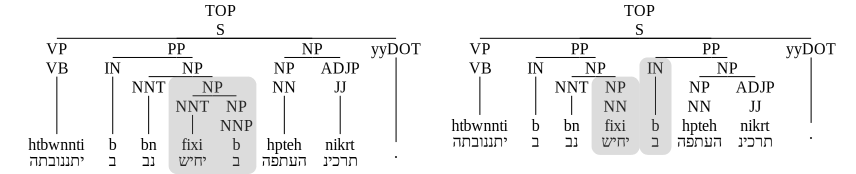

In [220]:
describe(11, [(0,1,1,1)], [(0,1,1,1), (0,2,0)])
token_parents = ", ".join([t[0] for t in get_possible_terminal_tags('FIXI')])
h3(f"שיחי parents in train set: {token_parents}")

---
As we can see below, the mistake here is marking __איזה__ as DT instead of WDT (question determiner)

We can see that איזה was indeed learnt to be a WDT in most cases, but NP is much more likely to be a parent of __DT X__ than a __WDT X__.

This use case shows the CKY may fail to parse less common sentence forms, like __questions__.

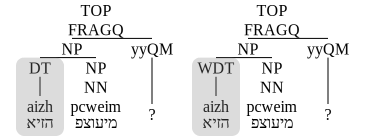

[('WDT', ('AIZH',), 0.0025128708016670747),
 ('DT', ('AIZH',), 0.0008810203054203724)]

[(('WDT', 'NP'), 0.00031025980176031614),
 (('WDT',), 8.164731625271477e-05),
 (('WDT', 'WDT*IN-NP'), 3.265892650108591e-05)]

[(('DT', 'NP'), 0.011136693936870294),
 (('DT', 'DT*IN-NP'), 0.00022861248550760135),
 (('DT', 'SBAR'), 0.00013063570600434365)]

In [221]:
describe(5, [(0,0,0)], [(0,0,0)])
h3("איזה parents")
display(get_possible_terminal_tags('aizh'))
h3("NP->WDT relation")
display(get_parent_to_child("NP","WDT","left"))
h3("NP->DT relation")
display(get_parent_to_child("NP","DT","left")[0:3])

---
As we can see, the marked token got the wrong tag, and consequently changed the sentence tree.

This happened as __טוקי__ didn't appear in the traning set at all.

In this case, we try to guess its POS based on a smoothing algorithm. Here it choose RB was has a better score than any noun tag, as טוקי appeared to be in the gold parse.

This use case shows the CKY will find it harder to parse sentences with __unknown words__.

Same thing accors below, as __מזהיבים__ isn't a known word:

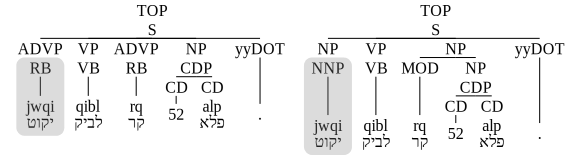

[]

25

30 32 36


In [222]:
describe(12, [(0,0,0)], [(0,0,0)])
h3("טוקי parents")
display(get_possible_terminal_tags('jwqi'))
h3("RB (adverb) score for unknown words (lower is better):")
display(get_unknown_score("RB"))
h3("NNP, NNT, NN scores for unknown words:")
print(get_unknown_score("NNP"), get_unknown_score("NNT"), get_unknown_score("NN"))

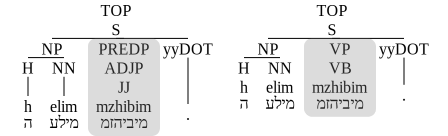

In [223]:
describe(24, [(0,1,)], [(0,1,)])

---
Here, frankly, it seems like a __mistake in the gold data__.

There's no reason why __אולי__ would be a adverb in this sentence.

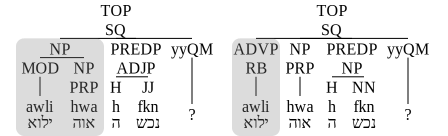

In [224]:
describe(61, [(0,0,)], [(0,0,)])

---
Many mistakes happen when parsing __proper nouns__, like __people names__, these are more unknown words that aren't treated properly.

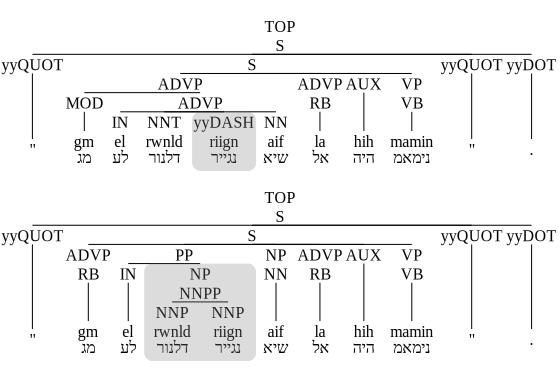

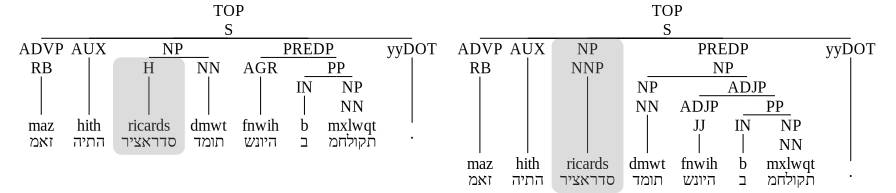

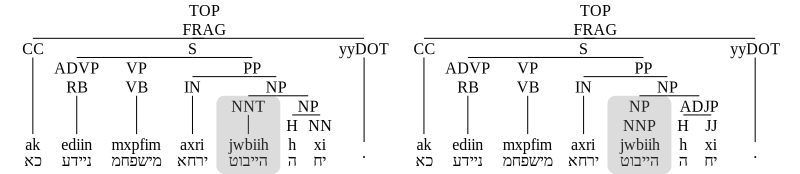

In [225]:
describe(71, [(0,1,0,1,2)], [(0,1,1,1)])
describe(83, [(0,2,0)], [(0,2,)])
describe(101, [(0,1,2,1,0)], [(0,1,2,1,0)])

## Now, let's gather some statistics

After we got a feeling from example mistakes, let's back it with data

In [226]:
s=evab_df['ID'].apply(lambda idn: contains_uknowns(predicted[idn])
#evalb_df['contains_unknowns'] = evab_df['ID'].apply(lambda idn: contains_uknowns(predicted[idn])

j=0
for i, line in enumerate(predicted):
    meta = evalb[i+1]['meta']
    if contains_uknowns(line) and meta['Tag Accracy']>90:
        j+=1
    if not line:
        continue
#     if meta['Tag Accracy']<80 and not contains_uknowns(line):
#         describe(i+1)
print(j)

SyntaxError: invalid syntax (<ipython-input-226-5b02755a6361>, line 4)

In [254]:
# For each row check if it contains unknown words

def does_contain_unknowns(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    for leaf in leafs:
        if leaf not in known_words:
            return True
    return False

def is_question(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    return leafs and leafs[-1] == 'yyQM'

evalb_df['Contain unknowns'] = evalb_df['ID'].apply(does_contain_unknowns)
evalb_df['Is question'] = evalb_df['ID'].apply(is_question)
evalb_df = evalb_df.assign(F1 = lambda x: 2 * x['Prec.'] * x['Recal'] / (x['Prec.'] + x['Recal']))

h3("Correlation between existance of unknown words, and other metrics")
evalb_df.corr()['Contain unknowns'].loc[['Tag Accracy', 'Prec.', 'Recal']]

Tag Accracy   -0.344373
Prec.         -0.353853
Recal         -0.303968
Name: Contain unknowns, dtype: float64

## Unknown words statistics

We can notice that sentences with unknown words are parsed less successfuly:

In [253]:
# Calc F1 for unknown words 

def df_f1(df):
    return round(df['F1'].mean(), 1)

h3("Different F1 scores")
print("F1 for all sentences", df_f1(evalb_df))
print("F1 for sentences with unknown words", df_f1(evalb_df[evalb_df['Contain unknowns']==True]))
print("F1 for sentences without unknown words", df_f1(evalb_df[evalb_df['Contain unknowns']==False]))

F1 for all sentences 72.5
F1 for sentences with unknown words 67.2
F1 for sentences without unknown words 83.2


We also notice that the vast majority of unknown words are tagged incorrectly, and that most sentences turned out to have unknown words in them.

In [257]:
import statistics

def unknown_mistake_ratio(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    unknown = 0
    mistakes = 0

    evalb_tags = evalb[int(line_num)]
    for i, leaf in enumerate(leafs):
        if leaf not in known_words:
            unknown += 1
            t_predicted = evalb_tags['t-predicted'][i]
            t_gold = evalb_tags['t-gold'][i]
            assert t_predicted['tag']==leaf
            assert t_gold['tag']==leaf
            if t_predicted['parent']!=t_gold['parent']:
                mistakes += 1
    return mistakes / unknown if unknown else None

unknown_words_ratio = statistics.mean(map(unknown_mistake_ratio, list(evalb_df[evalb_df['Contain unknowns']==True]['ID'])))

h3("Ratio of sentences with unknown words")
ratio = len(evalb_df[evalb_df['Contain unknowns']==True]) / len(evalb_df)
print(round(ratio,2)*100, '%')

h3("Ratio of unknown words taggaed incorrectly")
print(round(unknown_words_ratio,2)*100, '%')

66.0 %


71.0 %


In [256]:
evalb[1]

{'line': '(TOP (S (VP (VB KTWB)) (SBAR (yyCLN yyCLN) (S (yyQUOT yyQUOT) (S (PP (IN B) (NP (NN XWKMH))) (VP (VB EFH)) (PP (IN L) (NP (PRP ATH))) (NP (NN MLXMH))) (yyQUOT yyQUOT))) (yyDOT yyDOT)))',
 'meta': {'ID': 1.0,
  'Len.': 11.0,
  'Stat.': 0.0,
  'Recal': 100.0,
  'Prec.': 100.0,
  'Matched Bracket': 12.0,
  'Bracket gold': 12.0,
  'Bracket test': 12.0,
  'Cross Bracket': 0.0,
  'Words': 11.0,
  'Correct Tags': 11.0,
  'Tag Accracy': 100.0},
 't-predicted': [{'index': '0', '_': ':', 'parent': 'VB', 'tag': 'KTWB'},
  {'index': '1', '_': ':', 'parent': 'yyCLN', 'tag': 'yyCLN'},
  {'index': '2', '_': ':', 'parent': 'yyQUOT', 'tag': 'yyQUOT'},
  {'index': '3', '_': ':', 'parent': 'IN', 'tag': 'B'},
  {'index': '4', '_': ':', 'parent': 'NN', 'tag': 'XWKMH'},
  {'index': '5', '_': ':', 'parent': 'VB', 'tag': 'EFH'},
  {'index': '6', '_': ':', 'parent': 'IN', 'tag': 'L'},
  {'index': '7', '_': ':', 'parent': 'PRP', 'tag': 'ATH'},
  {'index': '8', '_': ':', 'parent': 'NN', 'tag': 'MLXMH'}

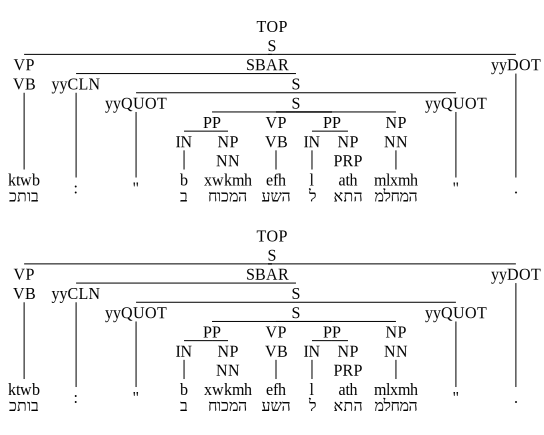

{'index': 0, '_': ':', 'start': 0, 'end': 11, 'tag': 'TOP'} 12
{'index': 1, '_': ':', 'start': 0, 'end': 11, 'tag': 'S'} 12
{'index': 2, '_': ':', 'start': 0, 'end': 1, 'tag': 'VP'} 3
{'index': 3, '_': ':', 'start': 1, 'end': 10, 'tag': 'SBAR'} 9
{'index': 4, '_': ':', 'start': 2, 'end': 10, 'tag': 'S'} 8
{'index': 5, '_': ':', 'start': 3, 'end': 9, 'tag': 'S'} 7
{'index': 6, '_': ':', 'start': 3, 'end': 5, 'tag': 'PP'} 3
{'index': 7, '_': ':', 'start': 4, 'end': 5, 'tag': 'NP'} 1
{'index': 8, '_': ':', 'start': 5, 'end': 6, 'tag': 'VP'} 1
{'index': 9, '_': ':', 'start': 6, 'end': 8, 'tag': 'PP'} 2
{'index': 10, '_': ':', 'start': 7, 'end': 8, 'tag': 'NP'} 1
{'index': 11, '_': ':', 'start': 8, 'end': 9, 'tag': 'NP'} 1


In [266]:
import statistics

def incorrect_NT_stats(line_num):
    eval_tags = evalb[int(line_num)]
    missed_location = defaultdict(int)
    for p in eval_tags['nt-predicted']:
        height = len([node for node in eval_tags['nt-predicted'] if p['start'] <= node['start'] < p['end']])
        print(p, height)
        # find the gold tag at the same position in the tree
        match_gold_nt = next((g for g in eval_tags['nt-gold'] if g['start']==p['start'] and g['end']==p['end']), None)
        if not match_gold_nt:
            missed_location
describe(1)
incorrect_NT_stats(1)

In [109]:
import networkx as nx
from collections import deque
from util.tree.builders import node_tree_from_sequence

def to_graph(line):
    G=nx.DiGraph()
    q = deque()
    node = node_tree_from_sequence(line)
    q.append((node, 0))
    while q:
        node,level = q.popleft()
        children = node.children
        if len(children):
            q.extend([(c, level+1) for c in children])
            for c in children:
                G.add_edge(f"{node.tag}-{level}",f"{c.tag}-{level+1}")
    return G

In [116]:
import networkx as nx
def draw(graph):
    pos=nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos, node_color='w')
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos)

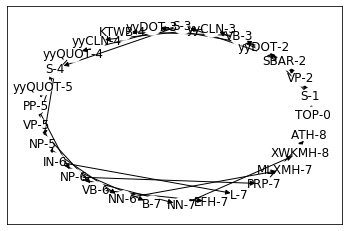

In [117]:
G=to_graph(predicted[0])
draw(G)
# nx.draw_networkx(G)

In [35]:
import networkx as nx
def analyze(predicted_line, gold_line):
    difference
